In [1]:
%load_ext autoreload
%autoreload 2
#this will reload all changed modules every time before executing a new line

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from nanofilm.ndimage import imread
import MyPacket.mypacket as mp

In [3]:
path_test_map = './data_demo/Flakesearch_Graphene_20180214175340935_087.png'

In [4]:
flake = mp.loadmap_astroclean(path_test_map)

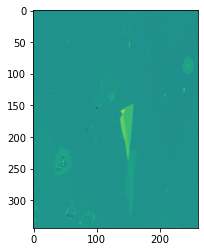

In [5]:
plt.imshow(flake, cmap='viridis');

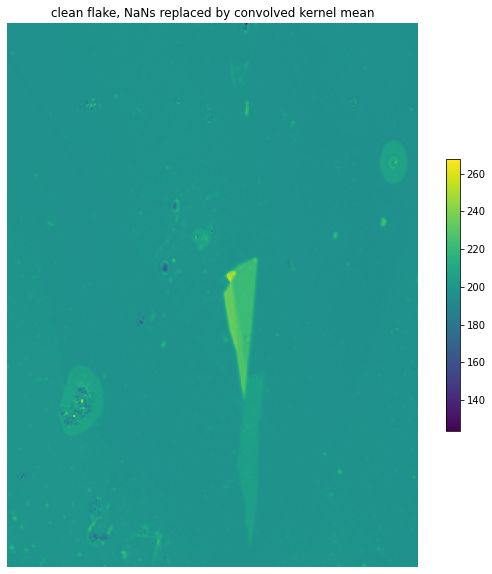

In [6]:
mp.plot_image_withCbar(flake, 'clean flake, NaNs replaced by convolved kernel mean');

In [7]:
flake.shape

(344, 260)

In [8]:
flakeReshaped = flake.reshape(flake.shape[0]*flake.shape[1], 1)

A single map is already a 2D array, but as it has only one channel (similar to a grayscale image), it needs to be reshaped to be a column, with the 1 as second parameter of the reshape.

In [9]:
flakeReshaped

array([[196.24716],
       [196.33598],
       [196.16315],
       ...,
       [197.86055],
       [197.19736],
       [196.33505]], dtype=float32)

In [10]:
from sklearn.cluster import KMeans

In [11]:
%%time
kmeans = KMeans(n_clusters=5, random_state=0).fit(flakeReshaped)
flakesegmented = kmeans.cluster_centers_[kmeans.labels_]


Wall time: 1.5 s


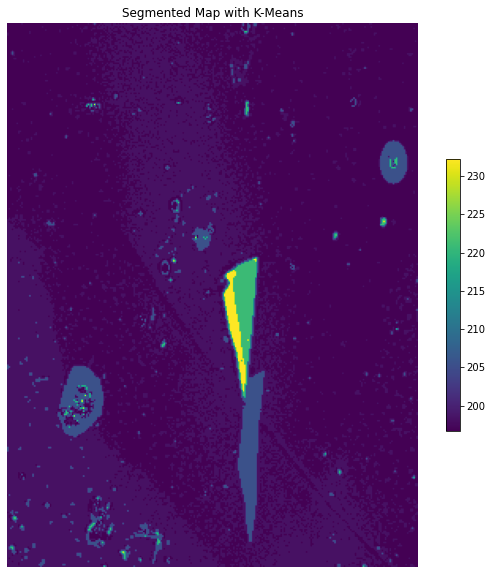

In [12]:
segmentedtoshow= flakesegmented.reshape(flake.shape[0], flake.shape[1])
mp.plot_image_withCbar(segmentedtoshow, 'Segmented Map with K-Means');

This seems to work fine :)

## Disadvantages and challenges:
   - application to a set of maps with dimension (rows, columns, [number of maps]
   - application to a set of combined delta and psi maps
   - the number of initial clusters must be set manually. Maybe this can be used as tunable parameter in the future front-end
   - loss of resolution on edges 

## To-Do:
   - ~~try Kmeans++~~ kmeans++ esta ya implementado dentro del kmeans normal
   - ~~try DBSCAN~~
   - ~~try segmentation by MeanShift~~ the result in the example looks awesome, but it can't be applied to our maps, since the imput image must be 8-bit 3 channel
   - apply canny (or other method) to detect edges in segmented image
   - ~~try also other example maps~~
   - explore how to get the metrics for the different number of clusters in the K-Means algorithm
    

### Clustering with DBSCAN

In [13]:
#from sklearn.cluster import DBSCAN

In [14]:
#dbscan = DBSCAN(eps=0.5, min_samples=100).fit(flakeReshaped)
#dbscansegmentedtoshow = (dbscan.labels_.reshape(flake.shape[0], flake.shape[1]))
#mp.plot_image_withCbar(dbscansegmentedtoshow, 'Segmented Map with DBSCAN');

DBSCAN is much worse than K-Means for this task:
- We still have to tune 2 parameters: eps and min_samples
- It is way too slow (in the order of minutes) 
- The output needs to be converted to uint8 for it to be plotted in the right scale, for some reason
- On top of that the result of the segmentation is too bad. 
One paper in the literature found showed nice results using DBSCAN, while in other examples found in the web, DBSCAN had the worse performance of all compared segmentation algorithms. 

(cells and outputs hidden or deactivated in order to speed up the re-running of the notebook)

# Test on squared sample map

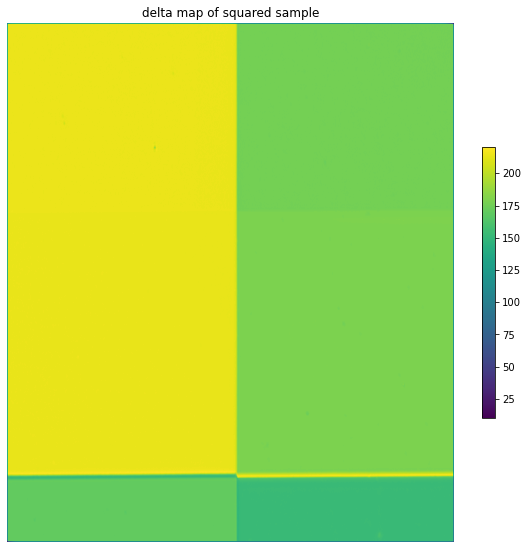

In [15]:
RCE_path = './data_demo/RCEvase/RCEvase_1zn_MapON_ScanON_AeON_FuE_2_Delta_0004.png'
delta = mp.loadmap_astroclean(RCE_path)
deltaTransposed = mp.loadmap_T_astroclean(RCE_path)
mp.plot_image_withCbar(deltaTransposed, 'delta map of squared sample')

In [16]:
deltaTReshaped = deltaTransposed.reshape(deltaTransposed.shape[0]*deltaTransposed.shape[1], 1)

In [17]:
kmeansD = KMeans(n_clusters=12, random_state=0).fit(deltaTReshaped)
deltaTSegmented = kmeansD.cluster_centers_[kmeansD.labels_]

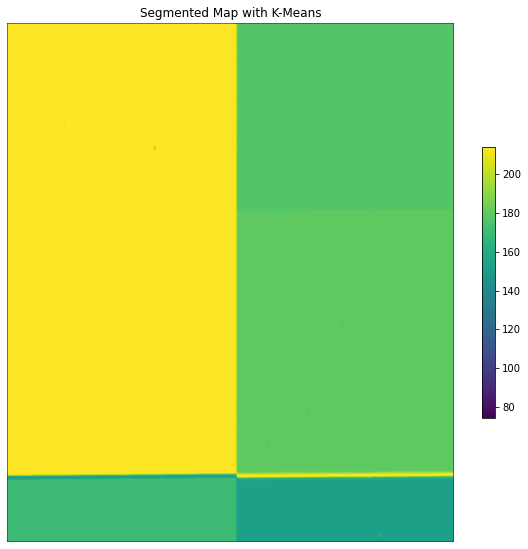

In [18]:
deltaTsegmentedtoshow = deltaTSegmented.reshape(deltaTransposed.shape[0], deltaTransposed.shape[1])
mp.plot_image_withCbar(deltaTsegmentedtoshow, 'Segmented Map with K-Means');

### Testing function from MyPacket for clustering with KMeans

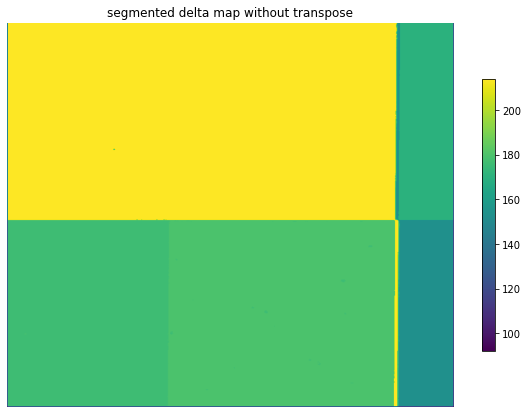

In [19]:
delta_segmented = mp.clusterKMeans_singlemap(delta, 6)
mp.plot_image_withCbar(delta_segmented, 'segmented delta map without transpose');

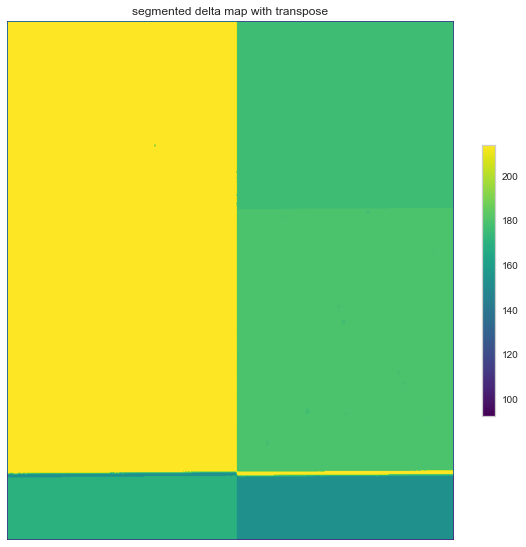

In [27]:
delta_T_segmented = mp.clusterKMeans_singlemap(deltaTransposed, 6)
mp.plot_image_withCbar(delta_T_segmented, 'segmented delta map with transpose');

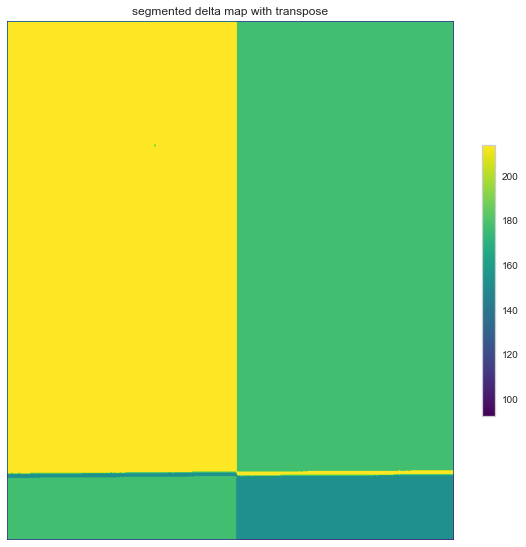

In [26]:
delta_T_segmented = mp.clusterKMeans_singlemap(deltaTransposed, 4)
mp.plot_image_withCbar(delta_T_segmented, 'segmented delta map with transpose');

Observations after this test:

- Transposing is necessary to keep the correct coordinates
- setting n_clusters >= 6 does not make any visible difference, 6 seems to find the largest number of squares, and <6 is obviously subobtimal. 

It would be convenient to find get some metrics of the clustering result with different n_clusters

## Exploring metrics methods for KMeans clustering

In [23]:
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import kelbow_visualizer

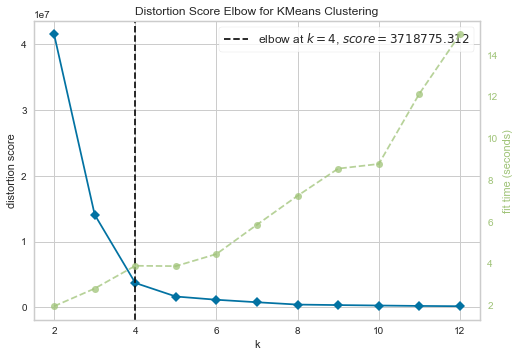

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [33]:
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(2,13))

visualizer.fit(deltaTReshaped)
visualizer.show()

This metric is obviously not definitive, as we have seen in the tests that the optimal number of clusters for this image is 6. Maybe the distortion metric is not the best for this sample or it simply has some room for tuning

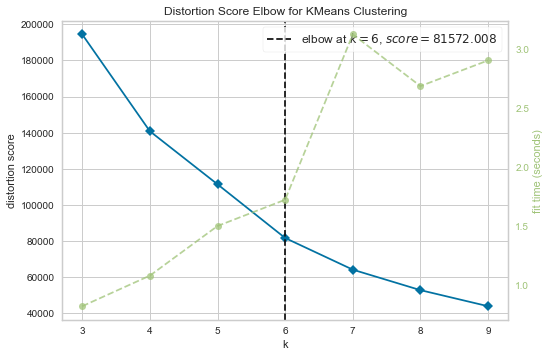

In [34]:
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(3,10))

visualizer.fit(flakeReshaped)
visualizer.show();

It seems to worrandom_state=er (and faster) in the flake image

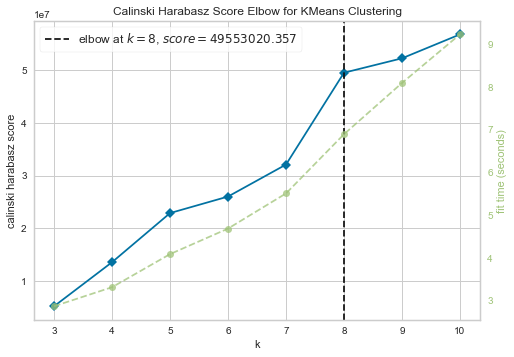

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [31]:
model = KMeans()
visualizer = KElbowVisualizer(model, 
                              k=(3,11), 
                              metric='calinski_harabasz')

visualizer.fit(deltaTReshaped)
visualizer.show()

Using the metric method 'Calinski-Harabasz', which computes the ratio of dispersion between and within clusters (instead of the squared distances to center within cluster used by distortion metric), the optimal number of cluster found is 8. This sample seems to be a bit challenging for the clustering metrics.

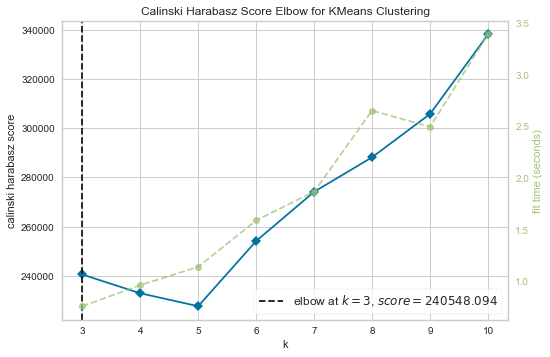

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [32]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,11),
                              metric='calinski_harabasz')

visualizer.fit(flakeReshaped)
visualizer.show()

ok, this metric does not make much sense at first glance. Why k=3 and not k=5?

#### Trying quick metric method

(this is faster only when typing it. Besides, it throws a long funny error despite the graph is shown. Writing a self made function with the "long" visualizer would probably have better effect)

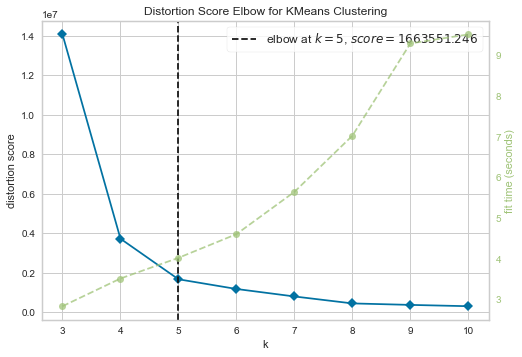

AttributeError: 'KMeans' object has no attribute 'k'

AttributeError: 'KMeans' object has no attribute 'k'

In [35]:
kelbow_visualizer(KMeans(random_state=0),
                  deltaTReshaped,
                  metric='distortion',
                  k=(3,11))